# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:37 - loss: 0.6940

  24/1875 [..............................] - ETA: 4s - loss: 0.5676   

  48/1875 [..............................] - ETA: 4s - loss: 0.4855

  68/1875 [>.............................] - ETA: 4s - loss: 0.4472

  94/1875 [>.............................] - ETA: 3s - loss: 0.4149

 114/1875 [>.............................] - ETA: 4s - loss: 0.3972

 137/1875 [=>............................] - ETA: 4s - loss: 0.3810

 165/1875 [=>............................] - ETA: 3s - loss: 0.3654

 185/1875 [=>............................] - ETA: 3s - loss: 0.3560

 208/1875 [==>...........................] - ETA: 3s - loss: 0.3467

 224/1875 [==>...........................] - ETA: 3s - loss: 0.3409

 251/1875 [===>..........................] - ETA: 3s - loss: 0.3321

 277/1875 [===>..........................] - ETA: 3s - loss: 0.3245

 302/1875 [===>..........................] - ETA: 3s - loss: 0.3180

 329/1875 [====>.........................] - ETA: 3s - loss: 0.3116

 352/1875 [====>.........................] - ETA: 3s - loss: 0.3066

 376/1875 [=====>........................] - ETA: 3s - loss: 0.3018

 402/1875 [=====>........................] - ETA: 3s - loss: 0.2970

 426/1875 [=====>........................] - ETA: 3s - loss: 0.2929

 456/1875 [======>.......................] - ETA: 3s - loss: 0.2881

 480/1875 [======>.......................] - ETA: 3s - loss: 0.2846

 505/1875 [=======>......................] - ETA: 2s - loss: 0.2811

 532/1875 [=======>......................] - ETA: 2s - loss: 0.2775

 559/1875 [=======>......................] - ETA: 2s - loss: 0.2742

 586/1875 [========>.....................] - ETA: 2s - loss: 0.2710

 616/1875 [========>.....................] - ETA: 2s - loss: 0.2677

 646/1875 [=========>....................] - ETA: 2s - loss: 0.2646

 677/1875 [=========>....................] - ETA: 2s - loss: 0.2615

 709/1875 [==========>...................] - ETA: 2s - loss: 0.2586

 737/1875 [==========>...................] - ETA: 2s - loss: 0.2561

 767/1875 [===========>..................] - ETA: 2s - loss: 0.2536

 797/1875 [===========>..................] - ETA: 2s - loss: 0.2511

 823/1875 [============>.................] - ETA: 2s - loss: 0.2491

 852/1875 [============>.................] - ETA: 2s - loss: 0.2470

 876/1875 [=============>................] - ETA: 1s - loss: 0.2453

 902/1875 [=============>................] - ETA: 1s - loss: 0.2435

 926/1875 [=============>................] - ETA: 1s - loss: 0.2419

 952/1875 [==============>...............] - ETA: 1s - loss: 0.2402

 978/1875 [==============>...............] - ETA: 1s - loss: 0.2386

1006/1875 [===============>..............] - ETA: 1s - loss: 0.2369

1030/1875 [===============>..............] - ETA: 1s - loss: 0.2355

1053/1875 [===============>..............] - ETA: 1s - loss: 0.2342

1076/1875 [================>.............] - ETA: 1s - loss: 0.2329

1101/1875 [================>.............] - ETA: 1s - loss: 0.2315

1127/1875 [=================>............] - ETA: 1s - loss: 0.2302

1150/1875 [=================>............] - ETA: 1s - loss: 0.2290

1177/1875 [=================>............] - ETA: 1s - loss: 0.2276

1204/1875 [==================>...........] - ETA: 1s - loss: 0.2263

1229/1875 [==================>...........] - ETA: 1s - loss: 0.2251

1255/1875 [===================>..........] - ETA: 1s - loss: 0.2239

1280/1875 [===================>..........] - ETA: 1s - loss: 0.2228

1304/1875 [===================>..........] - ETA: 1s - loss: 0.2218

1328/1875 [====================>.........] - ETA: 1s - loss: 0.2207

1352/1875 [====================>.........] - ETA: 1s - loss: 0.2197

1376/1875 [=====================>........] - ETA: 1s - loss: 0.2187

1401/1875 [=====================>........] - ETA: 0s - loss: 0.2177

1426/1875 [=====================>........] - ETA: 0s - loss: 0.2167

1451/1875 [======================>.......] - ETA: 0s - loss: 0.2158

1477/1875 [======================>.......] - ETA: 0s - loss: 0.2148

1503/1875 [=======================>......] - ETA: 0s - loss: 0.2138

1529/1875 [=======================>......] - ETA: 0s - loss: 0.2129

1553/1875 [=======================>......] - ETA: 0s - loss: 0.2120

1578/1875 [========================>.....] - ETA: 0s - loss: 0.2112

1603/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1628/1875 [=========================>....] - ETA: 0s - loss: 0.2095

1655/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1680/1875 [=========================>....] - ETA: 0s - loss: 0.2078

1706/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1733/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1760/1875 [===========================>..] - ETA: 0s - loss: 0.2053

1785/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1810/1875 [===========================>..] - ETA: 0s - loss: 0.2038

1836/1875 [============================>.] - ETA: 0s - loss: 0.2031

1861/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2020


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1092

  27/1875 [..............................] - ETA: 3s - loss: 0.1092

  53/1875 [..............................] - ETA: 3s - loss: 0.1093

  79/1875 [>.............................] - ETA: 3s - loss: 0.1094

 106/1875 [>.............................] - ETA: 3s - loss: 0.1094

 129/1875 [=>............................] - ETA: 3s - loss: 0.1094

 155/1875 [=>............................] - ETA: 3s - loss: 0.1094

 179/1875 [=>............................] - ETA: 3s - loss: 0.1094

 204/1875 [==>...........................] - ETA: 3s - loss: 0.1094

 228/1875 [==>...........................] - ETA: 3s - loss: 0.1094

 253/1875 [===>..........................] - ETA: 3s - loss: 0.1093

 278/1875 [===>..........................] - ETA: 3s - loss: 0.1093

 303/1875 [===>..........................] - ETA: 3s - loss: 0.1093

 328/1875 [====>.........................] - ETA: 3s - loss: 0.1092

 352/1875 [====>.........................] - ETA: 3s - loss: 0.1092

 377/1875 [=====>........................] - ETA: 3s - loss: 0.1091

 402/1875 [=====>........................] - ETA: 3s - loss: 0.1090

 427/1875 [=====>........................] - ETA: 2s - loss: 0.1090

 452/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 477/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 502/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 527/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 552/1875 [=======>......................] - ETA: 2s - loss: 0.1087

 577/1875 [========>.....................] - ETA: 2s - loss: 0.1087

 602/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 628/1875 [=========>....................] - ETA: 2s - loss: 0.1085

 653/1875 [=========>....................] - ETA: 2s - loss: 0.1085

 678/1875 [=========>....................] - ETA: 2s - loss: 0.1084

 704/1875 [==========>...................] - ETA: 2s - loss: 0.1084

 731/1875 [==========>...................] - ETA: 2s - loss: 0.1083

 757/1875 [===========>..................] - ETA: 2s - loss: 0.1082

 782/1875 [===========>..................] - ETA: 2s - loss: 0.1082

 808/1875 [===========>..................] - ETA: 2s - loss: 0.1081

 833/1875 [============>.................] - ETA: 2s - loss: 0.1081

 858/1875 [============>.................] - ETA: 2s - loss: 0.1080

 883/1875 [=============>................] - ETA: 2s - loss: 0.1080

 909/1875 [=============>................] - ETA: 1s - loss: 0.1079

 934/1875 [=============>................] - ETA: 1s - loss: 0.1078

 960/1875 [==============>...............] - ETA: 1s - loss: 0.1078

 986/1875 [==============>...............] - ETA: 1s - loss: 0.1077

1011/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1037/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1062/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1088/1875 [================>.............] - ETA: 1s - loss: 0.1075

1113/1875 [================>.............] - ETA: 1s - loss: 0.1075

1138/1875 [=================>............] - ETA: 1s - loss: 0.1074

1162/1875 [=================>............] - ETA: 1s - loss: 0.1074

1187/1875 [=================>............] - ETA: 1s - loss: 0.1073

1213/1875 [==================>...........] - ETA: 1s - loss: 0.1072

1240/1875 [==================>...........] - ETA: 1s - loss: 0.1072

1266/1875 [===================>..........] - ETA: 1s - loss: 0.1071

1291/1875 [===================>..........] - ETA: 1s - loss: 0.1071

1317/1875 [====================>.........] - ETA: 1s - loss: 0.1070

1342/1875 [====================>.........] - ETA: 1s - loss: 0.1070

1366/1875 [====================>.........] - ETA: 1s - loss: 0.1069

1392/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1417/1875 [=====================>........] - ETA: 0s - loss: 0.1068

1441/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1466/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1491/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1516/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1541/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1566/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1591/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1617/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1642/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1666/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1689/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1710/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1734/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1759/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1784/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1803/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1821/1875 [============================>.] - ETA: 0s - loss: 0.1061

1838/1875 [============================>.] - ETA: 0s - loss: 0.1061

1861/1875 [============================>.] - ETA: 0s - loss: 0.1061

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1060


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1037

  24/1875 [..............................] - ETA: 4s - loss: 0.1001

  49/1875 [..............................] - ETA: 3s - loss: 0.0995

  73/1875 [>.............................] - ETA: 3s - loss: 0.0994

  97/1875 [>.............................] - ETA: 3s - loss: 0.0993

 121/1875 [>.............................] - ETA: 3s - loss: 0.0993

 142/1875 [=>............................] - ETA: 3s - loss: 0.0993

 164/1875 [=>............................] - ETA: 3s - loss: 0.0992

 189/1875 [==>...........................] - ETA: 3s - loss: 0.0991

 215/1875 [==>...........................] - ETA: 3s - loss: 0.0991

 241/1875 [==>...........................] - ETA: 3s - loss: 0.0990

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0990

 293/1875 [===>..........................] - ETA: 3s - loss: 0.0989

 320/1875 [====>.........................] - ETA: 3s - loss: 0.0989

 345/1875 [====>.........................] - ETA: 3s - loss: 0.0988

 371/1875 [====>.........................] - ETA: 3s - loss: 0.0988

 396/1875 [=====>........................] - ETA: 3s - loss: 0.0988

 418/1875 [=====>........................] - ETA: 3s - loss: 0.0987

 444/1875 [======>.......................] - ETA: 2s - loss: 0.0987

 469/1875 [======>.......................] - ETA: 2s - loss: 0.0987

 495/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0986

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0986

 573/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 600/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0985

 650/1875 [=========>....................] - ETA: 2s - loss: 0.0985

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0985

 703/1875 [==========>...................] - ETA: 2s - loss: 0.0984

 726/1875 [==========>...................] - ETA: 2s - loss: 0.0984

 747/1875 [==========>...................] - ETA: 2s - loss: 0.0984

 770/1875 [===========>..................] - ETA: 2s - loss: 0.0984

 795/1875 [===========>..................] - ETA: 2s - loss: 0.0984

 818/1875 [============>.................] - ETA: 2s - loss: 0.0984

 844/1875 [============>.................] - ETA: 2s - loss: 0.0983

 866/1875 [============>.................] - ETA: 2s - loss: 0.0983

 889/1875 [=============>................] - ETA: 2s - loss: 0.0983

 914/1875 [=============>................] - ETA: 1s - loss: 0.0983

 933/1875 [=============>................] - ETA: 1s - loss: 0.0983

 956/1875 [==============>...............] - ETA: 1s - loss: 0.0983

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0982

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1027/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1079/1875 [================>.............] - ETA: 1s - loss: 0.0982

1104/1875 [================>.............] - ETA: 1s - loss: 0.0982

1129/1875 [=================>............] - ETA: 1s - loss: 0.0981

1154/1875 [=================>............] - ETA: 1s - loss: 0.0981

1180/1875 [=================>............] - ETA: 1s - loss: 0.0981

1204/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1231/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1281/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1322/1875 [====================>.........] - ETA: 1s - loss: 0.0980

1347/1875 [====================>.........] - ETA: 1s - loss: 0.0980

1371/1875 [====================>.........] - ETA: 1s - loss: 0.0980

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1544/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1668/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1693/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1840/1875 [============================>.] - ETA: 0s - loss: 0.0978

1871/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1031

  25/1875 [..............................] - ETA: 3s - loss: 0.0973

  50/1875 [..............................] - ETA: 3s - loss: 0.0968

  74/1875 [>.............................] - ETA: 3s - loss: 0.0965

 101/1875 [>.............................] - ETA: 3s - loss: 0.0964

 133/1875 [=>............................] - ETA: 3s - loss: 0.0963

 160/1875 [=>............................] - ETA: 3s - loss: 0.0962

 184/1875 [=>............................] - ETA: 3s - loss: 0.0962

 212/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 241/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 293/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 321/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 351/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 378/1875 [=====>........................] - ETA: 2s - loss: 0.0961

 406/1875 [=====>........................] - ETA: 2s - loss: 0.0961

 437/1875 [=====>........................] - ETA: 2s - loss: 0.0961

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 506/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 538/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 573/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 642/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 675/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 706/1875 [==========>...................] - ETA: 2s - loss: 0.0961

 740/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 774/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 809/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 844/1875 [============>.................] - ETA: 1s - loss: 0.0961

 878/1875 [=============>................] - ETA: 1s - loss: 0.0961

 911/1875 [=============>................] - ETA: 1s - loss: 0.0961

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0961

1010/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1079/1875 [================>.............] - ETA: 1s - loss: 0.0961

1113/1875 [================>.............] - ETA: 1s - loss: 0.0961

1147/1875 [=================>............] - ETA: 1s - loss: 0.0961

1182/1875 [=================>............] - ETA: 1s - loss: 0.0961

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1243/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1277/1875 [===================>..........] - ETA: 0s - loss: 0.0961

1310/1875 [===================>..........] - ETA: 0s - loss: 0.0961

1343/1875 [====================>.........] - ETA: 0s - loss: 0.0961

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1547/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1833/1875 [============================>.] - ETA: 0s - loss: 0.0960

1865/1875 [============================>.] - ETA: 0s - loss: 0.0960

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1079

  34/1875 [..............................] - ETA: 2s - loss: 0.0947

  68/1875 [>.............................] - ETA: 2s - loss: 0.0946

 101/1875 [>.............................] - ETA: 2s - loss: 0.0946

 133/1875 [=>............................] - ETA: 2s - loss: 0.0947

 164/1875 [=>............................] - ETA: 2s - loss: 0.0948

 193/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 227/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 260/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 294/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 327/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 361/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 428/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 460/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 496/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 529/1875 [=======>......................] - ETA: 2s - loss: 0.0950

 558/1875 [=======>......................] - ETA: 2s - loss: 0.0950

 592/1875 [========>.....................] - ETA: 1s - loss: 0.0950

 625/1875 [=========>....................] - ETA: 1s - loss: 0.0950

 659/1875 [=========>....................] - ETA: 1s - loss: 0.0950

 688/1875 [==========>...................] - ETA: 1s - loss: 0.0950

 717/1875 [==========>...................] - ETA: 1s - loss: 0.0950

 751/1875 [===========>..................] - ETA: 1s - loss: 0.0950

 786/1875 [===========>..................] - ETA: 1s - loss: 0.0950

 820/1875 [============>.................] - ETA: 1s - loss: 0.0950

 853/1875 [============>.................] - ETA: 1s - loss: 0.0950

 888/1875 [=============>................] - ETA: 1s - loss: 0.0950

 922/1875 [=============>................] - ETA: 1s - loss: 0.0950

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0950

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0950

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1091/1875 [================>.............] - ETA: 1s - loss: 0.0951

1126/1875 [=================>............] - ETA: 1s - loss: 0.0951

1159/1875 [=================>............] - ETA: 1s - loss: 0.0951

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1228/1875 [==================>...........] - ETA: 0s - loss: 0.0951

1260/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1294/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1329/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1364/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1399/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1435/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1529/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1595/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1836/1875 [============================>.] - ETA: 0s - loss: 0.0951

1870/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

Matplotlib is building the font cache; this may take a moment.


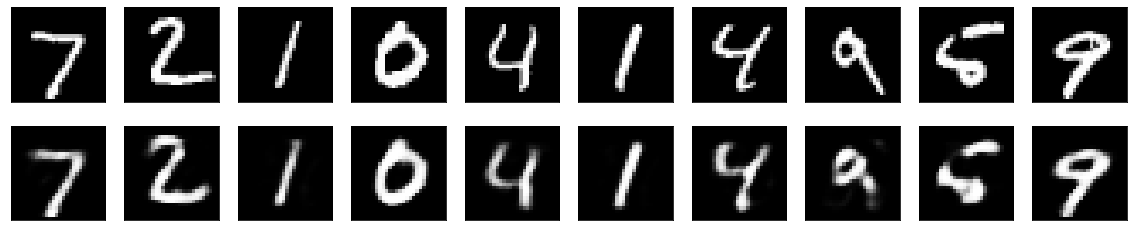

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
